In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import SyllableTokenizer
import string
from num2words import num2words
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import collections
from sklearn.model_selection import train_test_split



/Users/alexander/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pip install num2words

Note: you may need to restart the kernel to use updated packages.


# Change to your paths

In [2]:
raw_data_dir = '/Users/alexander/classes/nlg/data_raw/'
processed_data_dir = '/Users/alexander/classes/nlg/data/'

# Dataset generation

In [3]:
valid_chars = string.ascii_lowercase 
remove_chars = string.punctuation + '-—`’“”…‘–"\t'


In [4]:
valid_chars_dict = {}
for c in valid_chars:
    valid_chars_dict[c] = 1
valid_chars_dict[' '] = 1

In [5]:
remove_chars

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~-—`’“”…‘–"\t'

In [6]:
SSP = SyllableTokenizer()

def get_syllables(row,name):
    '''
    This uses nltk Syllable Tokenizer to approximate syllable count
    Has issues, for instance says fishing is 3 syllables but is quick and easy, syllable count is also
    a fairly minor part
    '''
    line = row[name]
   # print(SSP.tokenize(line))
    #print(line)
   # print(row.name)
    if row.name % 100 == 0:
        global SSP
        #must save something each time it is called, otherwise takes days to run
        SSP = SyllableTokenizer()
        #print(row.name)
    tokens = SSP.tokenize(line)
    #remove whitespaces from list
    count = 0
    for t in tokens:
        if not t.isspace():
            count += 1
    return count

#def convert_num_word(line):
def num_there(s):
    return any(i.isdigit() for i in s)

def remove_punctuation(line):
    '''
    Some poems have punctuation but this can mess with the model
    '''
   # print(line)
    line = str(line)

    line = line.translate(str.maketrans('', '', remove_chars))
    line = line.replace("'", "")
    line = line.lstrip()
    line = line.rstrip()
   # line = line.replace(",", "")
    try: line = line.lower()
    except:
        return line #if it fails must be invalid, will be removed next
    if num_there(line):
        #print(line)
        broke = line.split(' ')
        new_str = []
        for word in broke:
            if word.isnumeric():
                new_str.append(num2words(word))
            else:
                new_str.append(word)
        line = ' '.join(new_str)
        #print(line)
    line = line.translate(str.maketrans('', '', remove_chars))  
    
    
    return line

def check_valid(row):
    '''
    This is slow but only needs to be run once, verifies that there are no non-standard chars 
    '''
    for l_name in lines:
        line = row[l_name]
        for c in line:
            if c not in valid_chars_dict:
                #print(line)
                return False
        if num_there(line):
            print(line)
            return False
            
    return True
    

In [7]:
data_name = 'all_haiku.csv'

In [8]:
kaggle_df = pd.read_csv(raw_data_dir + data_name)
kaggle_df = kaggle_df.drop('Unnamed: 0',axis=1)

kaggle_df = kaggle_df.drop_duplicates(subset=['hash'])
kaggle_df = kaggle_df.drop('hash',axis=1)
kaggle_df = kaggle_df.rename(columns={"0": "line_0", "1": "line_1", "2": "line_2"})
kaggle_df = kaggle_df#[0:2000]

In [9]:
lines = ['line_0','line_1','line_2']
kaggle_df['valid'] = True
for line in lines:
    kaggle_df[line] = kaggle_df[line].apply(remove_punctuation)
    
kaggle_df['valid'] = kaggle_df.apply(check_valid,axis=1)
kaggle_df = kaggle_df[kaggle_df['valid']]
for line in lines:
    print(line)
    kaggle_df[line + '_scount'] = kaggle_df.apply(get_syllables,args=(line,),axis=1)

line_0


/Users/alexander/opt/anaconda3/lib/python3.9/site-packages/nltk/tokenize/sonority_sequencing.py:101: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  warnings.warn(


line_1
line_2


# Title Extraction
Run TF-IDF on entire corpus to approximate titles

In [10]:
#agglamate corpus
#poem_lines = kaggle_df[['line_0','line_1','line_2']]
poem_lines = kaggle_df['line_0'] + '\n' + kaggle_df['line_1'] + '\n' + kaggle_df['line_2'] 
poem_list = poem_lines.to_list()


In [11]:
poem_list[0:10]

['fishing boats\ncolors of\nthe rainbow',
 'ash wednesday\ntrying to remember\nmy dream',
 'snowy morn\npouring another cup\nof black coffee',
 'shortest day\nflames dance\nin the oven',
 'haze\nhalf the horse hidden\nbehind the house',
 'low sun\nthe lady in red\non high heels',
 'advent\nthe passing stranger\nfarts',
 'tarn\na bubble in\nthe ice',
 'snowflakes\nnew asphalt\nin the holes',
 'crystal night\ngusts of rain\noutside']

In [12]:

# our corpus
data = poem_list

cv = CountVectorizer()

# convert text data into term-frequency matrix
data = cv.fit_transform(data)

tfidf_transformer = TfidfTransformer()

# convert term-frequency matrix into tf-idf
tfidf_matrix = tfidf_transformer.fit_transform(data)

# create dictionary to find a tfidf word each word
word2tfidf = dict(zip(cv.get_feature_names(), tfidf_transformer.idf_))



In [42]:
idf_dict

AttributeError: 'collections.OrderedDict' object has no attribute 'sort'

In [13]:
articles = ['the','a','at', 'i', 'is', 'and','are','aint','im','you'] #add others, or dont do this isk
title_list = []
for i in range(len(poem_list)):
    idf_dict = collections.OrderedDict()
    for word in poem_list[i].split():
        if word not in articles:
            try: idf_dict[ word2tfidf[word]] = word
            except:
                #sometimes it doesnt work, doesnt mean infrequent just broken so ignore
                continue
    curr_title = []
    for idf in list(sorted(idf_dict.keys()))[::-1][0:2]:
        #print(idf_dict[idf])
        curr_title.append(idf_dict[idf])
    #curr_title.rstrip()

    title_list.append(' '.join(curr_title))
    #print('\n')
    

In [14]:
poem_data = pd.DataFrame(data= {'Poem': poem_list, 'Title': title_list})
#poem_data.to_csv(processed_data_dir + 'test_data.csv')

In [15]:
train_df, test_df = train_test_split(poem_data, test_size=0.05)

In [16]:
test_df.to_csv(processed_data_dir + 'test_data.csv')
train_df.to_csv(processed_data_dir + 'train_data.csv')

In [15]:
kaggle_df.to_csv(processed_data_dir + 'kaggle_data.csv')

In [17]:
test_df

,Poem,Title
130995,how can you escape\nthe saddened failure when ...,saddened burns
48886,but shoot and rover\nreally the same song you ...,rover shoot
67792,listened to robin\nwilliams stand up on the dr...,williams robin
11871,lo\nall our pomp of yesterday\nis one with nin...,nineveh tyre
52370,save the date batman\nand catwoman are getting...,catwoman batman
...,...,...
15034,awake and chase this fatal thought\nunclose\nt...,unclose fatal
132734,i really hope this\nopportunity works out\nfor...,crossed fingers
35898,what are the chances\nof liverpool winning the...,champions chances
123697,girl your expression\nis telling me that youve...,expression telling


In [17]:
kaggle_df

,line_0,line_1,line_2,source,valid,line_0_scount,line_1_scount,line_2_scount
0,fishing boats,colors of,the rainbow,tempslibres,True,4,3,3
1,ash wednesday,trying to remember,my dream,tempslibres,True,5,6,2
2,snowy morn,pouring another cup,of black coffee,tempslibres,True,3,7,6
3,shortest day,flames dance,in the oven,tempslibres,True,4,5,5
4,haze,half the horse hidden,behind the house,tempslibres,True,2,7,6
...,...,...,...,...,...,...,...,...
144118,im not asking did,you say it nor clarify,what you said neither,twaiku,True,7,10,8
144119,you are truly a,moron or a liar im,inclined to think both,twaiku,True,7,6,8
144120,aint no selfie on,this earth thats gonna make me,like theresa may,twaiku,True,6,11,6
144121,is doing a great,job turning independents,into democrats,twaiku,True,5,8,5


In [25]:
(kaggle_df['line_0_scount'])

6.913127399723663

# Plotting statistics of dataset

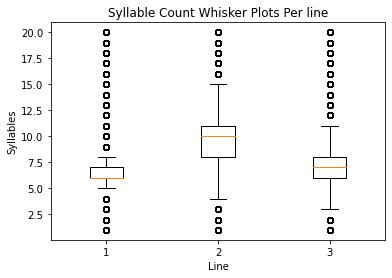

In [37]:
import matplotlib.pyplot as plt 
# Creating plot
#triming very large syllable counts to help visualization, remove around 3000 poems
kaggle_df_trimmed = kaggle_df[(kaggle_df['line_0_scount'] <= 20)]
kaggle_df_trimmed = kaggle_df_trimmed[(kaggle_df_trimmed['line_1_scount'] <= 20)]
kaggle_df_trimmed = kaggle_df_trimmed[(kaggle_df_trimmed['line_2_scount'] <= 20)]
plt.boxplot([kaggle_df_trimmed['line_0_scount'],kaggle_df_trimmed['line_1_scount'],kaggle_df_trimmed['line_2_scount']])
#plt.boxplot(kaggle_df['line_1_scount'])
 
# show plot
plt.title("Syllable Count Whisker Plots Per line")
plt.xlabel("Line")
plt.ylabel("Syllables")
plt.show()

In [63]:
np.mean(kaggle_df['line_2_scount'])

7.239225978462372

In [160]:
kaggle_df

,line_0,line_1,line_2,source,valid
0,fishing boats,colors of,the rainbow,tempslibres,True
1,ash wednesday,trying to remember,my dream,tempslibres,True
2,snowy morn,pouring another cup,of black coffee,tempslibres,True
3,shortest day,flames dance,in the oven,tempslibres,True
4,haze,half the horse hidden,behind the house,tempslibres,True
...,...,...,...,...,...
144118,im not asking did,you say it nor clarify,what you said neither,twaiku,True
144119,you are truly a,moron or a liar im,inclined to think both,twaiku,True
144120,aint no selfie on,this earth thats gonna make me,like theresa may,twaiku,True
144121,is doing a great,job turning independents,into democrats,twaiku,True


In [340]:
ls

data_processing.ipynb  data_raw/              processed_data_dir/


In [344]:
mkdir data

In [38]:
kaggle_df_trimmed

,line_0,line_1,line_2,source,valid,line_0_scount,line_1_scount,line_2_scount
0,fishing boats,colors of,the rainbow,tempslibres,True,4,3,3
1,ash wednesday,trying to remember,my dream,tempslibres,True,5,6,2
2,snowy morn,pouring another cup,of black coffee,tempslibres,True,3,7,6
3,shortest day,flames dance,in the oven,tempslibres,True,4,5,5
4,haze,half the horse hidden,behind the house,tempslibres,True,2,7,6
...,...,...,...,...,...,...,...,...
144118,im not asking did,you say it nor clarify,what you said neither,twaiku,True,7,10,8
144119,you are truly a,moron or a liar im,inclined to think both,twaiku,True,7,6,8
144120,aint no selfie on,this earth thats gonna make me,like theresa may,twaiku,True,6,11,6
144121,is doing a great,job turning independents,into democrats,twaiku,True,5,8,5


In [ ]:
gpt3_poems = ['em doesnt\nunderstand the feelings\nof my heart',
             ' aller sickness\nscrubbing the walls clean\nof all its dust',
            ' mississippi sky\ntornado of thoughts\nwhirling in the wind',
            'physician s touch\nmoreover, a caring heart\nfor healing wounds',
            'marlon leagues\nbatting and fielding\nthe diamond glistens',
            'professor s hour\nstudents ponder in silence\nquestions of knowledge',
            'teamwork warriors\nunited in spirit\nvictory is ours!',
            'connect four kills\nplaying the game of life\njust for the thrill',
             'max stupidity\nblindly following rules\njust won t do',
             'suggest ourselves\nto take a break\nfrom the daily grind'
            ]